# Built Graph
In this notebook we proceed building the ERN. In particular we create a graph characterized by the following structure:

* Nodes: authors of publications
* Edges: (u,v) if a coauthorship relation stands between u and v
* Weights: (u,v,w) where the weight corresponds to the number of common publications between u and v

For the tidiness of the code the used functions are stored in external modules which will be properly recalled when in use.

In [1]:
# Import useful library

from collections import defaultdict
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from BuildGraphModule import *
from AnalysisModule import *
from UniformData import *
from MultiGraph import *
from GraphPlot import *
import collections
import numpy as np
import requests
import pickle
import json

%matplotlib inline

##### Load data: 

The loaded data are in the form describe in [DATA ACQUISITION]. To remind:

                               {ID_paper_1:{'Abstract': 'text', 
                                            'Title' : 'title', 
                                            'Date of publication' : '1999', 
                                            'Authors' : [a1, a2, a3], 
                                            'Epfl authors' : [{'name_author':'web_page'}], 
                                            'Involved Labs' : [{'name_lab' : 'lab_web_site'}], 
                                            'Keywords' : [k1, k2, k3]}
                                            
    
*_Remark_*: due to the fact that the web pages don't always contain all the information, the dictionary related to each paper may vary. It implies that for the further analysis it may happen that the number of publications taken into account will vary according to the information it relies on.

In [2]:
with open('paper.json', 'r') as f:
    data = json.load(f)

Decode authors name in order to get rid of duplicates due to spell differences. The used fuctions are store in the module [`UniformData.py`]().

In [3]:
# Uniform strings - Authors
data = uniform_authors(data)

In [4]:
# Uniform strings - EPFL Authors
data = uniform_epfl_authors(data)

## General graph
 Before getting focused on the EPFL network, we built a graph that includes also the external researchers. The functions used in this section are stored in the module [`BuildGraphModule.py`]().

In [5]:
# Define the list of authors
authors = get_authors(data, 'Authors')

In [6]:
# Obtain dictionary which connect authors to an identification number (and the reverse)
dictionary_a_id, dictionary_id_a = create_authors_id(authors, 'all')

In order to define the graph, for each author we provide the list of people he collaborates with.

In [ ]:
# Define the dictionary (author, list collaborators)
dict_authors = list_coauthors(data)

 For each author we count the number of collaborations with the same colleague.

In [ ]:
# Compute the dictionary (author, dict(collaborator: number of common publication))
dict_numb_coll = number_collaborations(dict_authors)

Keep only the set of collaborators

In [ ]:
# Define the dictionary (author, set of collaborators)
dict_authors_set = set_coauthors(dict_authors)

Thus, define the edges of the graph.

In [ ]:
# Create edges
edges = create_edges(dict_authors_set, dictionary_a_id)

In [11]:
G = create_simple_graph(dictionary_id_a, edges)

Name: 
Type: Graph
Number of nodes: 161431
Number of edges: 17345810
Average degree: 214.9006


In [1]:
# Add weights
l = 0
for i,j in G.edges():
    G[i][j]['weight'] = dict_numb_coll[dictionary_id_a[i]][dictionary_id_a[j]]
    l += 1
    print (l)

NameError: name 'G' is not defined

### Graph measures 
We are now going to compute some coefficients that may give us an idea of the structure of the graph.

#### Degree distribution
The degree of a node (author) in our network corresponds to the number of authors the node has collaborated with. The degree distribution is the probability distribution of these degrees over the whole network. 

In [ ]:
G_deg = G.degree(G.nodes())
G_deg_values = sorted(G_deg.values(), reverse = True)

The following plot shows that the number of authors that collaborate with a huge number of researchers is very small. Whereas the number of nodes with low number of connections is high.

In [ ]:
plot_measures(G_deg_values, 'Degree distribution', 'Number of authors', 'Degree', 'degree_distribution')

#### PageRank centrality
The PageRank allows us to identify the most important authors in the network. It is a probability distribution used to represent the likelihood that we are able to randomly arrive at any particular author.

In [ ]:
pr_centrality = nx.pagerank(G)
tuples_pr = pr_centrality.items()
pr_sorted = sorted(pr_centrality.values(),reverse = True)

The distribution seems to be like the Zipf's law. Few have considerably high probability respect the other nodes. We don't prove it, it should have been done using the Kolmogorov-Smirnov test.

In [ ]:
plot_measures(pr_sorted, 'Page Rank centrality', 'Authors', 'Page Rank', 'page_rank_centrality')

#### Average clustering coefficient
How much, on average, authors tend to create groups characterised by a relatively high density of edges.

In [ ]:
avg_coeff = nx.average_clustering(G)

## EPFL graph

We built the EPFL network repeating the same aforementioned operations. The graph is trimmed by using only `Epfl authors`.

In [5]:
authors_epfl = get_authors(data, 'Epfl authors')
# Due to the format which the authors have been saved

# We initialize a new list
epfl_authors = []

# Then for each element in the previous list
for i in authors_epfl:
    # We unpack the content
    epfl_authors += list(i.keys())

In [6]:
# Id-Author / Author-ID
dictionary_a_id_epfl, dictionary_id_a_epfl = create_authors_id(epfl_authors, 'epfl')

In [7]:
# EPFL - COAUTORI NELLA LISTA DI EPFL AUTHORS
dict_authors_epfl = list_coauthors_epfl(data)

In [8]:
# Number of collaborations
dict_numb_coll_epfl = number_collaborations(dict_authors_epfl)

In [9]:
# Coauthors set
dict_authors_set_epfl = set_coauthors(dict_authors_epfl)

In [10]:
# Set of edges
edges_epfl = create_edges(dict_authors_set_epfl, dictionary_a_id_epfl)

In [11]:
# Build the graph
G = create_simple_graph(dictionary_id_a_epfl, edges_epfl)

Name: 
Type: Graph
Number of nodes: 13451
Number of edges: 45417
Average degree:   6.7530


Comparing the dimension and the composition of the two built network, the one made up by only EPFL researchers is:

* Almost ten times smaller in terms of authors, for each EPFL author there are 9 from another university. 
* The number of connections between authors is drastically reduced. It may be explaind by the fact that, due to the fact that the *external* (no EPFL) nodes are a way more than the *internal* (EPFL), the probability of having a connection with someone in the graph is higher, hence we obtain more edges.
* The number of average degree, which represents the average number of people any authors collaborate with, in the entire graph is high (214), and is 35 times bigger than the one in the EPFL network. It is interesting, since it may be said that the community research connected to EPFL is international, it is because most of the collaborators are from outside EPFL.

In [12]:
# Add weights to the edges
for i,j in G.edges():
    G[i][j]['weight'] = dict_numb_coll_epfl[dictionary_id_a_epfl[i]][dictionary_id_a_epfl[j]]

#### Perform the same algorithms and measures only on EPFL graph

In [13]:
G_deg = G.degree(G.nodes())
G_deg_values = sorted(G_deg.values(), reverse = True)

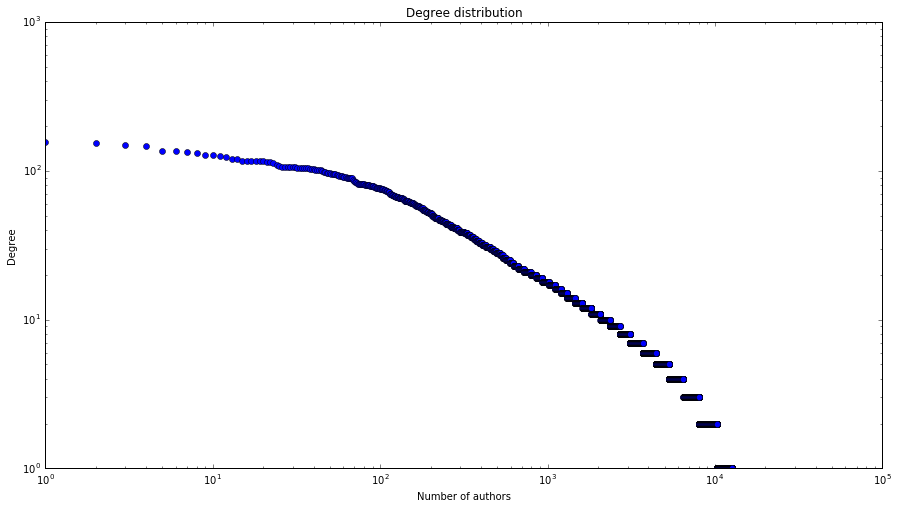

In [14]:
plot_measures(G_deg_values, 'Degree distribution', 'Number of authors', 'Degree', 'degree_distribution')

Also for the ERN, we see that only few authors have a really high number of connection, a lot of them just less than 10 connections (that's why the average results to be around 6).

In [15]:
pr_centrality = nx.pagerank(G)
tuples_pr = pr_centrality.items()
pr_sorted = sorted(pr_centrality.values(),reverse = True)

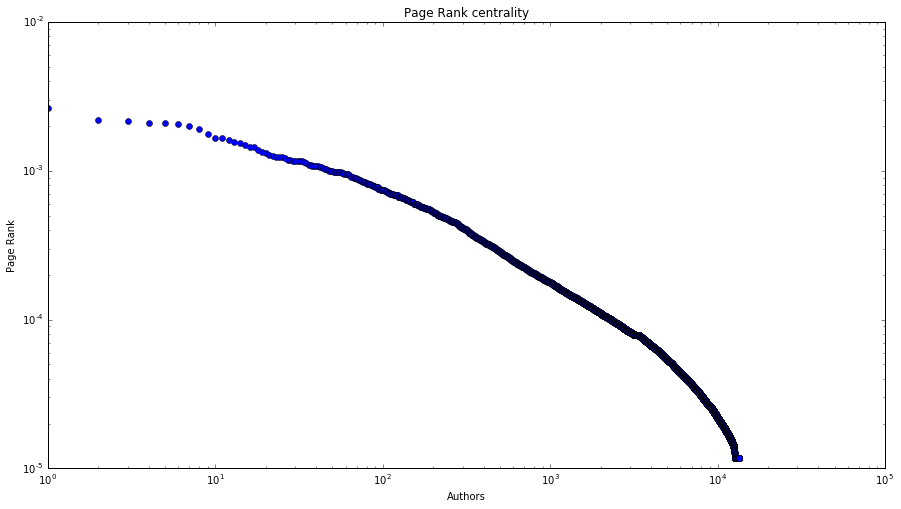

In [16]:
plot_measures(pr_sorted, 'Page Rank centrality', 'Authors', 'Page Rank', 'page_rank_centrality')

The number of authors that have high probability of being reached from the others are few. We extract the 10 most important. 

*__Remark__*: we run on the EPFL the PageRank making the assumption that the graph is complete. Anyway interpreting the top authors as the most important, we should keep in mind that the obtained values may be dependent on the exclusion of *external* EPFL authors. 

##### Top 10 authors according to the PageRank

In [17]:
# Sort the PageRank values
pr_centralities_sorted = sorted(tuples_pr, key = getKey)
# Keep the best 10
top_10_pr_centr = pr_centralities_sorted[-10:]

In [18]:
# Get the list of the name
list_top_ten = []
for i in top_10_pr_centr:
    # Append element to the list
    list_top_ten += [dictionary_id_a_epfl[i[0]]]

The following list of name corresponds to the top 10 authors. It goes from the 10th to the first.

In [19]:
list_top_ten

['renaud philippe',
 'aberer karl',
 'thiran jean-philippe',
 'de micheli giovanni',
 'leblebici yusuf',
 'vetterli martin',
 'perriard yves',
 'marechal francois',
 'schleiss anton',
 'graetzel michael']

##### Average clustering coefficient

The average clustering coefficient results to be quite high, moreover it is a way bigger than that obtain from a random graph.

In [20]:
avg_coeff = nx.average_clustering(G)
avg_coeff

0.5448363209546241

#### First observation about the structure of the Epfl Researchers Network

The ERN is a __*small-world*__: most researcher have not collaborated together, but the co-authors of any given researcher are likely to be co-authors of each other (avg clustering coef). Moreover, most authors can be reached from every other by a small number of hops (average short path).

#### Before analysing

We retrive the range of year we are working with.

In [21]:
# Get the range of years
dict_years = defaultdict(int)
# For each paper
for paper in list(data.keys()):
    # Whether the paper instance has the date specified
    try:
        dict_years[data[paper]['Publication date']] += 1
    # If not go on
    except:
        continue

In [22]:
# Get rid of the unidentified years
del dict_years['August 31-September 2 2005']
del dict_years['0']

We thake a brief look at the paper distribution over the entire period.

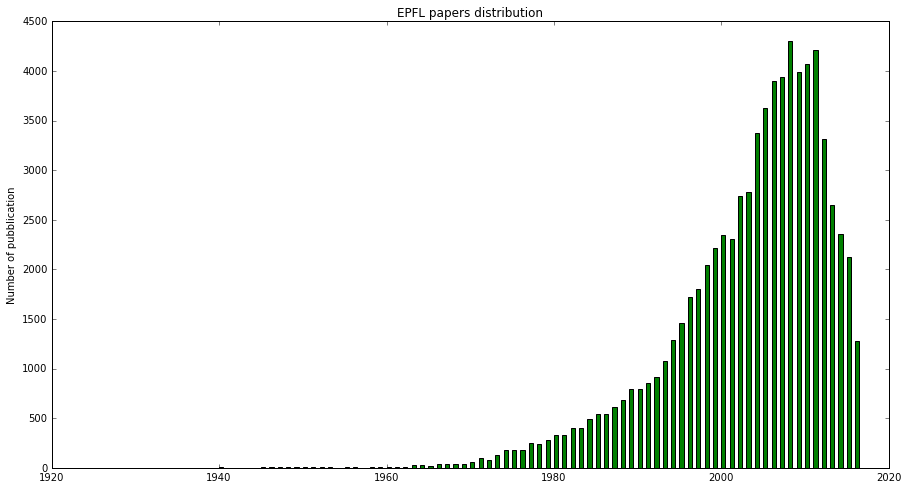

In [23]:
plt.figure(figsize=(15,8), dpi=80)
plt.bar(dict_years.keys(), dict_years.values(), 0.5, color='g')
plt.ylabel('Number of pubblication')
plt.title("EPFL papers distribution")

After a first glance twe observe that:
* The oldest publications are those which may contain fragmented and incomplete information
* The number of publication in considerably higher from the latest 90s to nowdays

As consequence we decide to focus our attention on the publications between 1993 and 2015/6. The function in use is stored in [`MultiGraph.py`]() module.

In [24]:
# Hence, we cut the data we work on
data_cut = cut_data(data)

Regarding the selected data, we observe the during the last years the production of paper is reducing. The plausible explanation for this phenomenon is that the EPFL is aiming to an higher quality production insted of a quantitative one.

#### Further data gaining
In order to explore the ERN such that interaction between schools and labs is possible, we should proceed scraping the specific lab an author belongs to and the school a lab is part of.

##### A. Scrape EPFL structure
* We scrape the EPFL structure from the EPFL website, which result to have a tree structure.

In order to speed up the operations, before traverse the tree, we reduce the branches to explore just selectiong the school's ones.

* From the root of the tree (EPFL) we extract the urls related to the schools. In particular we consider:
 - ENAC: SCHOOL OF ARCHITECTURE, CIVIL AND ENVIRONMENTAL ENGINEERING
 - IC: SCHOOL OF COMPUTER AND COMMUNICATION SCIENCES
 - STI: SCHOOL OF ENGINEERING
 - SB: SCHOOL OF BASIC SCIENCES
 - SV: SCHOOL OF LIFE SCIENCE

In [25]:
# From the root (EPFL): obtain the first level of the tree (schools)

#req = requests.get('https://search.epfl.ch/ubrowse.action?acro=EPFL')
#html = req.content
#soup = BeautifulSoup(html, 'html.parser')

# Get the urls for the schools

#new_links_to_go = []
#dictio = []
# Go to the second level of the tree
#for i in soup.findAll('div', {'class':'unit_name'}):
    # Keep only the schools
#    if i.findAll('a')[0].text.strip()[:6] == 'School':
#        new_links_to_go += [i.findAll('a')[0].get('href')]
#        dictio += [i.findAll('a')[0].text.strip()]

* So, for each school we traverse the tree until the labs level. To do so we use the function `tracerse_epfl_tree` stored in module [`MultiGraph.py`]().

In [26]:
#prova = {}
#traverse_epfl_tree('https://search.epfl.ch/ubrowse.action?acro=IC')

* The data is dumped in separate file for each school.

In [27]:
# Store the result related to each different school
#pickle.dump(prova, open('IC.p', 'wb')) 

Then, to each lab we connect the school.
1. Get informations about the labs
2. Connect 

In [28]:
# We built three different dictionary that may be used later. The function documentation provides informations about
dict_lab_site, dict_labs, dict_labs_paper = lab_dictionaries(data_cut)

###### Top 10 labs in according to the number of pubblications

In [29]:
dict_labs_sorted = sorted(dict_labs.items(), key=lambda value: value[1], reverse = True)

In [30]:
dict_labs_sorted[:10]

[('Swiss Plasma Center', 3344),
 ('Center for Research In Plasma Physics', 3221),
 ('Offered in consultation at the EPFL Library', 1622),
 ("L'IDIAP Laboratory", 1376),
 ('Transportation and Mobility Laboratory', 1186),
 ('Human and social sciences teaching program', 1146),
 ('Sensors, Actuators and Microsystems Laboratory', 1085),
 ('Urban Sociology Laboratory', 825),
 ('Electromagnetics and Acoustics Laboratory', 808),
 ('Laboratory of Photonics and Interfaces', 764)]

* Connect lab to school. Function `school_lab` stored in [`MultiGraph.py`]() module.

In [31]:
#lab_school = school_lab(dict_lab_site, 'IC')

##### B. Get lab for each author
We retrieve the labs of authors using this logic: whether only one lab is mentioned on InfoScience page, the EPFL authors are assumed to belong to that lab. Whether more than one lab is involved, we scrape the People page of the author. This procedure can lead to loosing some information since the pages of authors that are no more part of the EPLF have no longer the page on People.

In [32]:
# Get the dictionary (author, list collaborators with info)
dict_authors_epfl = get_collaborators(data)

In [33]:
# Get the dictionary (author, dict(collaborator,list of common works))
dict_coautorship_papers = coauthorship_papers(dict_authors_epfl)

In [34]:
# Define the dictionary (authos, set of papers)
list_paper = paper_per_author(dict_coautorship_papers)

Apply the function ([`MultiGraph.py`]()) to have the correspondence. And store what obtained.

In [35]:
#author_lab = get_authors_lab(list_paper, data)[0]
#pickle.dump(author_lab, open('author_lab.p', 'wb')) # Store the variable in a file.

In [36]:
lab = pickle.load(open('author_lab.p', 'rb'))

* Little example of what we get

In [37]:
lab['catasta michele']

'Distributed Information Systems Laboratory'

### School growth over the years



In [38]:
# Get the list of paper lab and year. Dictionary (lab, dict(year, list of papers))
dict_lab_years_pub = lab_year_pub(dict_labs_paper, data_cut)

In [39]:
# Dictionary (year, total number of papers)
year_papers = year_papers_(dict_lab_years_pub)

In [40]:
dict_author_year = lab_author_year(dict_lab_years_pub, data_cut)

In [41]:
# Get dictionary (lab, dict(year,num of pubblication))
dict_lab_years = lab_year(dict_labs_paper, data_cut)

In [42]:
# Dictionary (year, number of authors)
year_authors = year_auth(dict_lab_years)

We represent the distribution of publication between 1993-2016. The number are different from the previous plot since we filter them by lab and not every paper has the attribute labs.

In [43]:
def getKey_0(item):
    return item[0]

In [44]:
def get_sorted_array(dict_school_pub):
    
    tuples_pr = dict_school_pub.items()
    sort = sorted(tuples_pr, key = getKey_0)
    x = [int(i[0]) for i in sort[:-1]]
    y = [i[1] for i in sort[:-1]]
    
    return y,x

In [45]:
y,x = get_sorted_array(year_papers)
ind = np.arange(1993,2017)

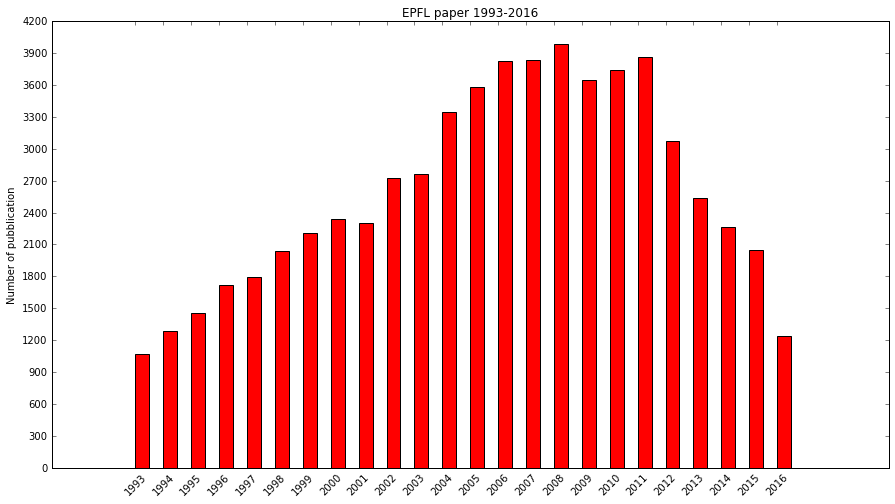

In [46]:
plt.figure(figsize=(15,8), dpi=80)
plt.bar(x, y, color = 'r', width=0.5)
plt.ylabel('Number of pubblication')
plt.title("EPFL paper 1993-2016")
plt.xticks(ind, np.arange(1993,2017), rotation = 45)
plt.yticks(np.arange(0, 4300, 300))
plt.savefig('epfl_activity.png', dpi=100)

In [47]:
list_schools = ['ENAC', 'SB', 'IC', 'STI', 'SV']
dict_school_pub = {}
dict_school_authors = {}

In [48]:
# Dictionary (School, dict(year, number of publication))
for school in list_schools:
    sc_labs = school_lab(dict_lab_site, school)
    dict_school_pub = school_publication(sc_labs, school, dict_lab_years, dict_school_pub)

In [49]:
total_year = defaultdict(int)
for school in list_schools:
    for year in list(dict_school_pub['ENAC'].keys()):
        total_year[year] += dict_school_pub[school][year]

In [50]:
def get_sorted_array_scaled(dict_school_pub, school, total_year):
    
    tuples_pr = dict_school_pub[school].items()
    sort = sorted(tuples_pr, key = getKey_0)
    x = [int(i[0]) for i in sort[:-1]]
    y = [i[1]/total_year[i[0]] for i in sort[:-1]]
    
    return y,x

In [51]:
ENAC_scaled = get_sorted_array_scaled(dict_school_pub, 'ENAC', total_year)[0]
IC_scaled = get_sorted_array_scaled(dict_school_pub, 'IC', total_year)[0]
SV_scaled = get_sorted_array_scaled(dict_school_pub, 'SV', total_year)[0]
SB_scaled = get_sorted_array_scaled(dict_school_pub, 'SB', total_year)[0]
STI_scaled = get_sorted_array_scaled(dict_school_pub, 'STI', total_year)[0][:-1]

In [52]:
N = 23
ind = np.arange(1993,2016)
width = 0.5 
colours = ['Red','Darkred','Pink','Blue','Lime']#,'Coral','Olive','SteelBlue','Yellow','Orange']

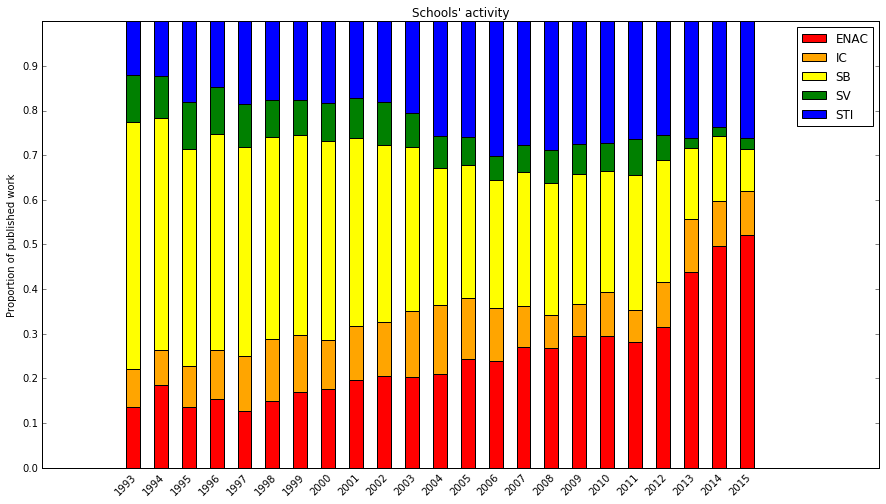

In [53]:
plt.figure(figsize=(15,8), dpi=80)
p1 = plt.bar(ind, ENAC_scaled, width, color = 'red')
p5 = plt.bar(ind, IC_scaled, width, bottom=ENAC_scaled, color = 'orange')
p4 = plt.bar(ind, SB_scaled, width, bottom=[i+j for i,j in list(zip(ENAC_scaled, IC_scaled))], color = 'yellow')
p2 = plt.bar(ind, SV_scaled, width, bottom=[i+j+k for i,j,k in list(zip(ENAC_scaled, IC_scaled, SB_scaled))], color = 'green')
p3 = plt.bar(ind, STI_scaled, width, bottom=[i+j+k+l for i,j,k,l in list(zip(ENAC_scaled, IC_scaled, SB_scaled,SV_scaled))], color = 'blue')

plt.legend((p1[0], p5[0], p4[0], p2[0], p3[0]), ('ENAC', 'IC', 'SB', 'SV', 'STI'))

plt.ylabel('Proportion of published work')
plt.title("Schools' activity")
plt.xticks(ind, np.arange(1993,2016), rotation = 45)
plt.yticks(np.arange(0, 1, 0.1))
plt.savefig('school_activity_scaled.png', dpi=100)

In [54]:
# Dictionary (School, dict(year, number of authors))
for school in list_schools:
    sc_labs = school_lab(dict_lab_site, school)
    dict_school_authors = school_author(sc_labs, school, dict_author_year, dict_school_authors)

In [55]:
ratio_productivity = []
for school in list_schools:
    for year in list(dict_school_authors[school].keys()):
        try:
            ratio_productivity += [(dict_school_pub[school][year],dict_school_authors[school][year])]
        except:
            continue    

In [56]:
import pandas as pd
df = pd.DataFrame(ratio_productivity, columns=['Publications', 'Authors'])

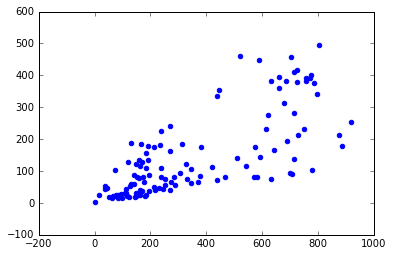

In [57]:
plt.scatter(df['Publications'], df['Authors'], marker='o', color='b')

In [58]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

In [59]:
regr = linear_model.LinearRegression()

In [60]:
regr.fit( df['Authors'].to_frame(), df['Publications'].to_frame())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

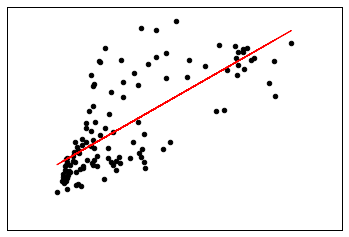

In [61]:
plt.scatter(df['Authors'].to_frame(), df['Publications'].to_frame(),  color='black')
plt.plot(df['Authors'].to_frame(), regr.predict(df['Authors'].to_frame()), color='red', linewidth=1)
plt.xticks(())
plt.yticks(())
plt.show()

In [62]:
regr.score(df['Authors'].to_frame(), df['Publications'].to_frame())

0.54510605590358607

### Internationality

In [63]:
# Get the range of years
dict_years = defaultdict(int)
dict_year_authors = defaultdict(float)
dict_year_epfl_authors = defaultdict(float)
dict_authors = defaultdict(float)
for paper in list(data.keys()):
    try:
        #print (paper['Publication date'])
        dict_years[data[paper]['Publication date']] += 1
        dict_year_authors[data[paper]['Publication date']] += len(data[paper]['Authors'])
        dict_year_epfl_authors[data[paper]['Publication date']] += len(data[paper]['Epfl authors'])
        
    except:
        pass
    try:
        for author in data[paper]['Epfl authors']:
            dict_authors[author.keys()[0]] += 1
    except:
        continue

In [64]:
dict_year_authors.pop('0', None)
dict_year_authors.pop('August 31-September 2 2005', None)
dict_year_authors.pop('2017', None)

12.0

In [65]:
def normalize_dict(d):
    factor=1.0/sum(list(d.values()))
    for k in d:
        d[k] = d[k]*factor
    return d

In [66]:
open_measure = defaultdict(float)
open_measure_scaled = defaultdict(float)
for year in list(dict_year_authors.keys()):
    open_measure[year] = (dict_year_epfl_authors[year] / dict_year_authors[year])
    open_measure_scaled[year] = (dict_year_epfl_authors[year] / dict_year_authors[year])*dict_years[year]

In [67]:
import numpy as np

In [68]:
def getKey(item):
    return item[0]

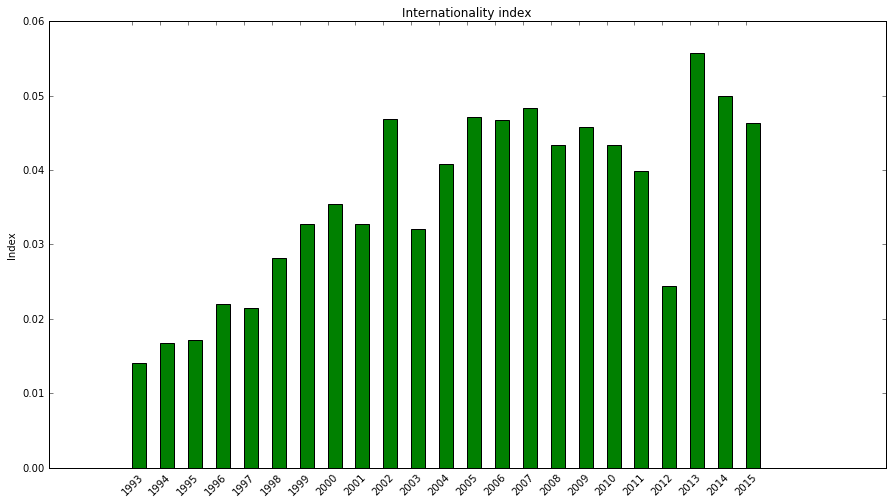

In [69]:
plt.figure(figsize=(15,8), dpi=80)
ind = np.arange(1993,2016)
open_measure_scaled.pop('0', None)
open_measure_scaled.pop('August 31-September 2 2005', None)
open_measure_scaled.pop('2017', None)
normalize_dict(open_measure_scaled)
tuples_pr = open_measure_scaled.items()
sort = sorted(tuples_pr, key = getKey)
x = [int(i[0]) for i in sort[-24:-1]]
y = [i[1] for i in sort[-24:-1]]
plt.bar(x, y, 0.5, color='g')

plt.ylabel('Index')
plt.title("Internationality index")
plt.xticks(ind, np.arange(1993,2016), rotation = 45)
#plt.yticks(np.arange(0, 2900, 300))
plt.savefig('internationality.png', dpi=100)

In [70]:
lab = pickle.load(open('author_lab.p', 'rb'))

### EPFL Map

In [71]:
data_cut = {}
for paper in list(data.keys()):
    try:
        if int(data[paper]['Publication date']) == 2014:
            data_cut[paper] = data[paper]
    except:
        continue

In [72]:
dict_lab_site, dict_labs, dict_labs_paper = lab_dictionaries(data_cut)

In [73]:
# Dictionary (lab, id)
dict_lab_id = {}
for  id_,lab in enumerate(list(dict_labs_paper.keys())):
    dict_lab_id[lab] = id_
    
dict_id_lab = {v: k for k, v in dict_lab_id.items()}

In [77]:
# Define edges of the graph: labs that writes papers together
# Dictionary (Lab, dict(lab, publication together))
dict_edges = {}
for lab in list(dict_labs_paper.keys()):
    dict_edges[lab] = defaultdict(list) 
    for lab_2 in list(dict_labs_paper.keys()):
        if lab_2 != lab:
            list_intersection = [p for p in dict_labs_paper[lab] if p in dict_labs_paper[lab_2]]
            if len(list_intersection) != 0:
                dict_edges[lab][lab_2] += list_intersection
            #dict_edges[lab_2][lab] += [p for p in dict_labs_paper[lab] if p in dict_labs_paper[lab_2]]

In [78]:
school_lab_dict = {}
for school in list_schools:
    school_lab_dict.update(school_lab(dict_lab_site, school))

In [79]:
# Get the list of edges and weigths for the edges
edges = []
weigths = {}
for lab in dict_edges:
    if len(dict_edges[lab]) != 0:
        for lab_2 in dict_edges[lab]:
            edges += sorted([(dict_lab_id[lab], dict_lab_id[lab_2])])
            weigths[(dict_lab_id[lab], dict_lab_id[lab_2])] = len(dict_edges[lab][lab_2])

In [80]:
dict_school_pub_edges = defaultdict(int)
for edge in list(weigths.keys()):
    try:
        dict_school_pub_edges[school_lab_dict[dict_id_lab[edge[0]]], school_lab_dict[dict_id_lab[edge[1]]]] += weigths[edge]
    except:
        continue

* WHich is the school with the highest number of labs

In [81]:
counter=collections.Counter(list(school_lab_dict.values()))

In [82]:
counter

Counter({'ENAC': 51, 'IC': 31, 'SB': 44, 'STI': 52, 'SV': 13})

In [83]:
# Exlude collaborations between same school
for key in list(dict_school_pub_edges.keys()):
    if key[0] == key[1]:
        del dict_school_pub_edges[key]

In [84]:
total_paper = sum(list(dict_school_pub_edges.values()))

In [85]:
# Collaborations intra schools
dict_inter_school_pub = defaultdict(int)
for key in list(dict_school_pub_edges.keys()):
    pair_school = tuple(sorted([key[0], key[1]]))
    dict_inter_school_pub[pair_school] += dict_school_pub_edges[key]/total_paper

In [86]:
dict_inter_school_pub

defaultdict(int,
            {('ENAC', 'IC'): 0.19298245614035087,
             ('ENAC', 'SB'): 0.10526315789473684,
             ('ENAC', 'STI'): 0.24561403508771928,
             ('ENAC', 'SV'): 0.03508771929824561,
             ('IC', 'SB'): 0.03508771929824561,
             ('IC', 'STI'): 0.03508771929824561,
             ('IC', 'SV'): 0.03508771929824561,
             ('SB', 'STI'): 0.21052631578947367,
             ('SB', 'SV'): 0.03508771929824561,
             ('STI', 'SV'): 0.07017543859649122})

In [87]:
X_1 = 532700
X_2 = 533507
Y_1 = 152693
Y_2 = 152242

In [88]:
X_1_scaled = 0
X_2_scaled = 807
Y_1_scaled = 451
Y_2_scaled = 0

In [89]:
# Scaled coordinates
coordinate_ENAC = (152571-Y_2, 533078- X_1)
coordinate_IC = (152292-Y_2, 532818- X_1, )
coordinate_SV = (152457-Y_2, 532815- X_1)
coordinate_SB = (152526-Y_2, 533263- X_1)
coordinate_STI = (152399-Y_2, 532938- X_1)

In [90]:
dict_school = {list_schools[i]:i+1 for i in range(len(list_schools))}

In [91]:
# Create the grid 113 x 202 each patch is 4x4
#empty_map = np.zeros((113,202))
empty_map = np.zeros((451,807))

In [92]:
ranges_X = np.arange(X_1_scaled, X_2_scaled, 1)
ranges_Y = np.arange(Y_2_scaled, Y_1_scaled, 1)

In [93]:
school_center_map = {'ENAC': coordinate_ENAC, 'IC':coordinate_IC, 'SV':coordinate_SV, 'SB':coordinate_SB, 'STI':coordinate_STI}

In [94]:
dict_coordinates = {'ENAC': coordinate_ENAC, 'IC':coordinate_IC, 'SV':coordinate_SV, 'SB':coordinate_SB, 'STI':coordinate_STI}

In [95]:
# Define distances between points
import math
dict_distances = defaultdict(int)
for school in list(dict_coordinates.keys()):
    for school_1 in list(dict_coordinates.keys()):
        if school != school_1:
            dict_distances[(school, school_1)] = math.sqrt( (school_center_map[school][0] - school_center_map[school_1][0])**2 + (school_center_map[school][1] - school_center_map[school_1][1])**2 )

In [96]:
dict_distance_inter_school = defaultdict(int)
for key in list(dict_distances.keys()):
    pair_school = tuple(sorted([key[0], key[1]]))
    dict_distance_inter_school[pair_school] += dict_distances[key]

#### Define the score function
   $$QP_u = \frac{\sum_{v}[ (1-\theta_{uv}) \times||(u,v)||^2_2]}{\sum_{\text{all pairs }(u,v)}[ (1-\theta_{uv}) \times||(u,v)||^2_2]}$$
   
where:

* $QP_u$: quality position of the school $u$
* $\theta_{uv}$: is the proportion of work produced by both u and v over the number of all publication between two schools

Thus, the index varies between 0 and 1. Greater it is better is positioned the school according to its research contribution.

In [97]:
# 2014
dict_theta = {}
for pairs in list(dict_distances.keys()):
    dict_theta[(pairs[0],pairs[1])] = dict_inter_school_pub[pairs]
    dict_theta[(pairs[1],pairs[0])] = dict_inter_school_pub[pairs]
    #if pairs in list(dict_school_pub_edges.keys()):
     #   dict_theta[pairs] = dict_inter_school_pub[pairs]
    #else:
     #   dict_theta[pairs] = 0

In [98]:
dict_index = {}
list_index = []
for pairs in list(dict_distances.keys()):
    list_index += [dict_distances[pairs] * (1-dict_theta[pairs])]
    dict_index[pairs] = dict_distances[pairs] * (1-dict_theta[pairs])

In [99]:
denominator = sum(list_index)

In [100]:
qp_dictionary = {}
for school in list_schools:
    list_school_score = [dict_index[key] for key in list(dict_distances.keys()) if key[0] == school]
    qp_dictionary[school] = sum(list_school_score)/4#/denominator

In [101]:
qp_dictionary

{'ENAC': 267.53073664281385,
 'IC': 298.0757323934778,
 'SB': 369.43539964332393,
 'STI': 214.48236130313364,
 'SV': 255.33557727459174}

In [102]:
def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

In [103]:
epfl_map =np.zeros((451,807))
#x,y center position
size_x, size_y = 451,807
#score ; score of the center
sigma_school = dict_coordinates = {'ENAC': 60, 'IC':40, 'SV':40, 'SB':50, 'STI': 40}
#Modify map according to the center score
for school in list(school_center_map.keys()):
    for i in range(size_x):
        for j in range(size_y):
            #calculate gaussian distr sigma is space factor
            disc = gauss(np.sqrt(((size_x - school_center_map[school][0])-i)**2+((school_center_map[school][1])-j)**2),[0, 2*sigma_school[school]])
            epfl_map[i][j] += disc*qp_dictionary[school]

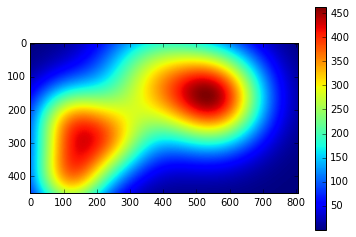

In [104]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import griddata
epfl_grey = mpimg.imread('map_school.png')
plt.imshow(epfl_map)
#plt.imshow(epfl_grey, alpha = 0.3)
plt.colorbar()
plt.show()
#plt.imsave('plot_map.png')